In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from yellowbrick.regressor import ResidualsPlot

%matplotlib inline

In [2]:
#Set some environment defaults like:
sns.set(style="darkgrid", color_codes=True)

<h2>1. Data Access</h2>

In [3]:
#Read data from MS Excel Format, parameter sheet_name was provided to access the specific task within an Excell book.
simd = pd.read_excel('https://www.gov.scot/binaries/content/documents/govscot/publications/statistics/2020/01/scottish-index-of-multiple-deprivation-2020-indicator-data/documents/simd_2020_indicators/simd_2020_indicators/govscot%3Adocument/SIMD%2B2020v2%2B-%2Bindicators.xlsx?forceDownload=true',sheet_name='Data')
simd.head()

,Data_Zone,Intermediate_Zone,Council_area,Total_population,Working_age_population,Income_rate,Income_count,Employment_rate,Employment_count,CIF,...,PT_GP,PT_post,PT_retail,Broadband,crime_count,crime_rate,overcrowded_count,nocentralheat_count,overcrowded_rate,nocentralheat_rate
0,S01006506,Culter,Aberdeen City,894,580,0.08,71,0.08,49,65,...,8.863589,5.856135,6.023406,0.105051,11.139188,124.59942,87,10,0.102113,0.011737
1,S01006507,Culter,Aberdeen City,793,470,0.05,43,0.05,25,45,...,9.978272,7.515000,7.926029,0.013587,10.126535,127.69905,85,4,0.101675,0.004785
2,S01006508,Culter,Aberdeen City,624,461,0.06,40,0.04,19,45,...,8.620700,4.321493,5.770910,0.005634,8.101228,129.827368,31,8,0.048212,0.012442
3,S01006509,Culter,Aberdeen City,537,307,0.1,52,0.08,26,80,...,7.935112,8.433328,8.329819,0.113074,4.050614,75.430426,42,6,0.072414,0.010345
4,S01006510,Culter,Aberdeen City,663,415,0.1,68,0.08,32,95,...,5.568964,6.966429,6.632609,0.003096,11.139188,168.011888,50,7,0.086655,0.012132


<h2>2. General Data characteristics and Data Cleaning</h2>

In [4]:
simd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6976 entries, 0 to 6975
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Data_Zone               6976 non-null   object 
 1   Intermediate_Zone       6976 non-null   object 
 2   Council_area            6976 non-null   object 
 3   Total_population        6976 non-null   int64  
 4   Working_age_population  6976 non-null   int64  
 5   Income_rate             6976 non-null   object 
 6   Income_count            6976 non-null   int64  
 7   Employment_rate         6976 non-null   object 
 8   Employment_count        6976 non-null   int64  
 9   CIF                     6976 non-null   object 
 10  ALCOHOL                 6976 non-null   object 
 11  DRUG                    6976 non-null   object 
 12  SMR                     6976 non-null   object 
 13  DEPRESS                 6976 non-null   object 
 14  LBWT                    6976 non-null   

As we can see above theoretically we have no null values within the dataset, however we know from the dataset description that some NULL (missing) data has been replaced with star. The indication of that happening could be Dtype of type object specified for some attributes which we expect to be a numbers e.g. Income_rate, Employment_rate etc. 

Remove unrelevant data attributes and deal with missing values.

Missing and suppressed data
In some data zones, the population in the considered age range is zero for some years. In these cases, a rate cannot be determined. This is denoted  by '*'.
Data have been suppressed for some indicators for reasons of disclosure control where small numbers are involved. This is also indicated by '&ast;'. 


In [5]:
def clean_SIMD(s):
    #Remove unrelevant data attributes leaving only Health and income related fields.
    s.drop(s.columns[list(range(19,29))], axis=1, inplace=True)
    s.drop(['Total_population','Working_age_population','Income_count','Employment_count','Attendance','Attainment','no_qualifications','crime_count','crime_rate','overcrowded_count','overcrowded_rate','nocentralheat_count','nocentralheat_rate','Broadband','PT_retail','LBWT'], axis=1, inplace=True)
  
    #Number of attributes are of data type 'object' - considering the above we will replace '*' with 0 and convert the column to numeric type.
    #Some values are converted to numeric (float) and some to integer form as apropriet for the attribute e.g. percentages values will be represented as float and standarised or cases per 10K like crime will be integer.
    s.loc[(s.Income_rate == '*'),'Income_rate']='0'
    s.Income_rate = pd.to_numeric(s.Income_rate)
    s.loc[(s.Employment_rate == '*'),'Employment_rate']='0'
    s.Employment_rate = pd.to_numeric(s.Employment_rate)
    s.loc[(s.CIF == '*'),'CIF']='0'
    s.CIF = s['CIF'].astype(int)
    s.loc[(s.ALCOHOL == '*'),'ALCOHOL']='0'
    s.ALCOHOL = s['ALCOHOL'].astype(int)
    s.loc[(s.DRUG == '*'),'DRUG']='0'
    s.DRUG = s['DRUG'].astype(int)
    s.loc[(simd.SMR == '*'),'SMR']='0'
    s.SMR = s['SMR'].astype(int)
    s.loc[(simd.DEPRESS == '*'),'DEPRESS']='0'
    s.DEPRESS = pd.to_numeric(simd.DEPRESS)
    s.loc[(s.EMERG == '*'),'EMERG']='0'
    s.EMERG = s['EMERG'].astype(int)


    print("Cleaning SIMD finished...")
    print("Checking dataset for NULL values within numerical attributes:")
    print(s.select_dtypes(['float64','int64']).isnull().any())
    print("Checking dataset finished - all values above should read 'False'")
    return s

In [6]:
simd = clean_SIMD(simd)

Cleaning SIMD finished...
Checking dataset for NULL values within numerical attributes:
Income_rate        False
Employment_rate    False
CIF                False
ALCOHOL            False
DRUG               False
SMR                False
DEPRESS            False
EMERG              False
dtype: bool
Checking dataset finished - all values above should read 'False'


In [7]:
simd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6976 entries, 0 to 6975
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Data_Zone          6976 non-null   object 
 1   Intermediate_Zone  6976 non-null   object 
 2   Council_area       6976 non-null   object 
 3   Income_rate        6976 non-null   float64
 4   Employment_rate    6976 non-null   float64
 5   CIF                6976 non-null   int64  
 6   ALCOHOL            6976 non-null   int64  
 7   DRUG               6976 non-null   int64  
 8   SMR                6976 non-null   int64  
 9   DEPRESS            6976 non-null   float64
 10  EMERG              6976 non-null   int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 599.6+ KB


Some indicators are in form of Standardised ratios.
A value of 100 is the Scotland average 

<h2>3. Exploratory Data Analysies</h2>

In [8]:
simd.describe()

,Income_rate,Employment_rate,CIF,ALCOHOL,DRUG,SMR,DEPRESS,EMERG
count,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000
mean,0.122847,0.095595,102.611812,101.908974,97.694954,99.123567,0.190637,100.495843
std,0.096105,0.071015,57.308775,98.054216,134.699719,46.198642,0.053782,34.978150
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040000,0.040000,55.000000,35.000000,15.000000,69.000000,0.149452,74.000000
50%,0.100000,0.080000,90.000000,73.000000,50.000000,92.000000,0.186778,95.000000
75%,0.180000,0.140000,140.000000,137.000000,133.000000,120.000000,0.227546,123.000000
max,0.590000,0.470000,370.000000,1656.000000,1826.000000,824.000000,0.471842,399.000000


<AxesSubplot:>

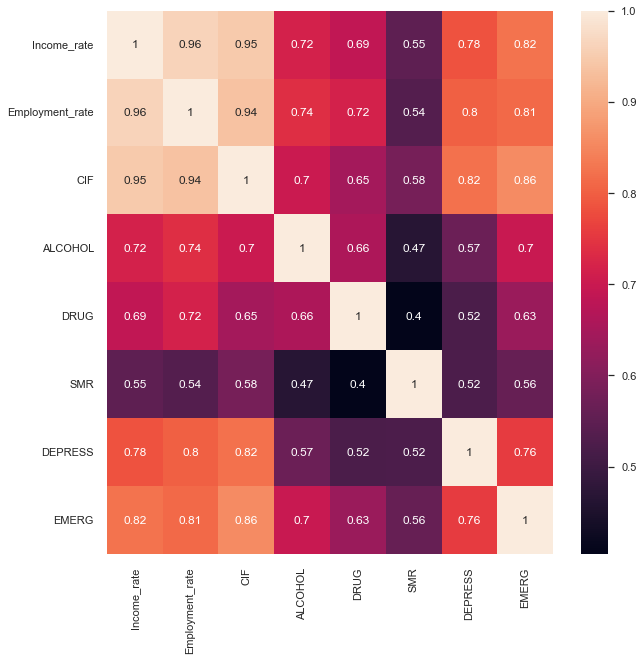

In [9]:
correlation = pd.DataFrame(simd[simd.columns[list(range(3,11))]])
corrMatrix = correlation.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True)

The employment and income rate are highly corelated - corelation rate is 0.96 - we will use employment rate as a target variable and in next steps we will try to estabilish which components have the biggest impact in terms of improving employment rate.

Looking at the above corelation matrix it looks like we might be having problem with multicollinearity problem described in this article: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/ . 
Let's calculate the vif components using the function below:

In [10]:
# Import library for VIF
# Source code: https://gist.githubusercontent.com/aniruddha27/579153e1c77773d7a7038b548f929b57/raw/9ac37b7120770ca6e2a005bf7beb944a00f1bfc0/Multicollinearity_VIF.py

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [11]:
X = simd.iloc[:,3:]
calc_vif(X)

,variables,VIF
0,Income_rate,47.202020
1,Employment_rate,49.473610
2,CIF,60.243802
3,ALCOHOL,5.287891
4,DRUG,3.564568
5,SMR,8.671563
6,DEPRESS,28.327666
7,EMERG,34.344762


We will drop <i>Income_rate</i> as this is highly related to employment rate. Improving employability of people is going also to reduce income depravation, so we will stick with one target variable defined as the Deprived <i>Employment_rate</i>

We also drop <i>EMERG,DEPRESS and SMR</i> features as recommended by the statsmodel documentation. https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
<i>"recommendation is that if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this."</i>

We do leave ALCOHOL related hospitalisation indicator as it is only slightly above 5 and we will observe the VIF value for it in the next pass of the <i>calc_vif</i> function.

In [12]:
simd.drop(['Income_rate','EMERG','DEPRESS','SMR'], axis=1, inplace=True)

In [13]:
X = simd.iloc[:,4:]
calc_vif(X)

,variables,VIF
0,CIF,4.313942
1,ALCOHOL,4.765670
2,DRUG,2.900392


In [14]:
simd.describe()

,Employment_rate,CIF,ALCOHOL,DRUG
count,6976.000000,6976.000000,6976.000000,6976.000000
mean,0.095595,102.611812,101.908974,97.694954
std,0.071015,57.308775,98.054216,134.699719
min,0.000000,0.000000,0.000000,0.000000
25%,0.040000,55.000000,35.000000,15.000000
50%,0.080000,90.000000,73.000000,50.000000
75%,0.140000,140.000000,137.000000,133.000000
max,0.470000,370.000000,1656.000000,1826.000000


In [15]:
#Lets take a copy of the data just for the NLC extent.
nlc = simd.loc[(simd.Council_area == 'North Lanarkshire')].copy()
nlc.describe()  

,Employment_rate,CIF,ALCOHOL,DRUG
count,447.000000,447.000000,447.000000,447.000000
mean,0.117562,134.071588,128.049217,88.595078
std,0.068328,49.498374,103.149973,99.522849
min,0.010000,30.000000,0.000000,0.000000
25%,0.060000,95.000000,48.500000,21.000000
50%,0.120000,140.000000,105.000000,59.000000
75%,0.160000,170.000000,173.500000,121.000000
max,0.440000,280.000000,570.000000,769.000000


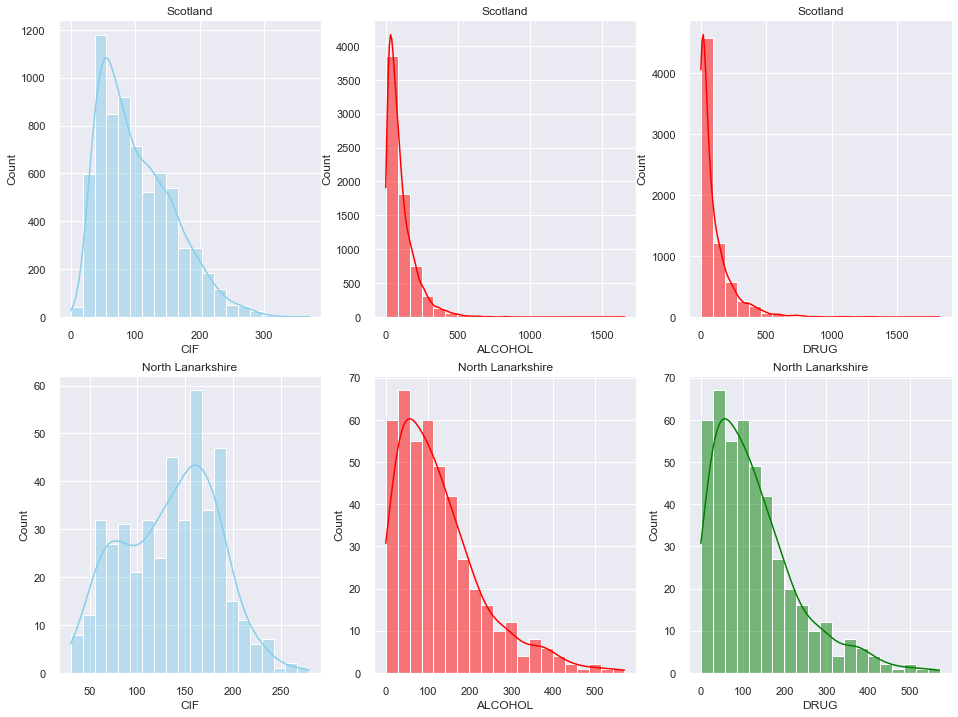

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(16, 12))
#Plot Scotland row
sns.histplot(data=simd, x="CIF", kde=True, bins=20, alpha = .5, color="skyblue",  ax=axs[0, 0])
axs[0,0].set(xlabel='CIF', title='Scotland')
sns.histplot(data=simd, x="ALCOHOL", kde=True, bins=20, alpha = .5, color="red",  ax=axs[0, 1])
axs[0,1].set(xlabel='ALCOHOL', title='Scotland')
sns.histplot(data=simd, x="DRUG", kde=True, bins=20, alpha = .5, color="red",  ax=axs[0, 2])
axs[0,2].set(xlabel='DRUG', title='Scotland')
#Plot NLC row
sns.histplot(data=nlc, x="CIF", kde=True, bins=20, alpha = .5, color="skyblue",  ax=axs[1, 0])
axs[1,0].set(xlabel='CIF', title='North Lanarkshire')
sns.histplot(data=nlc, x="ALCOHOL", kde=True, bins=20, alpha = .5, color="red",  ax=axs[1, 1])
axs[1,1].set(xlabel='ALCOHOL', title='North Lanarkshire')
sns.histplot(data=nlc, x="ALCOHOL", kde=True, bins=20, alpha = .5, color="green",  ax=axs[1,2])
axs[1,2].set(xlabel='DRUG', title='North Lanarkshire')
plt.show()


/Users/osedok/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/osedok/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/osedok/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/osedok/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defi

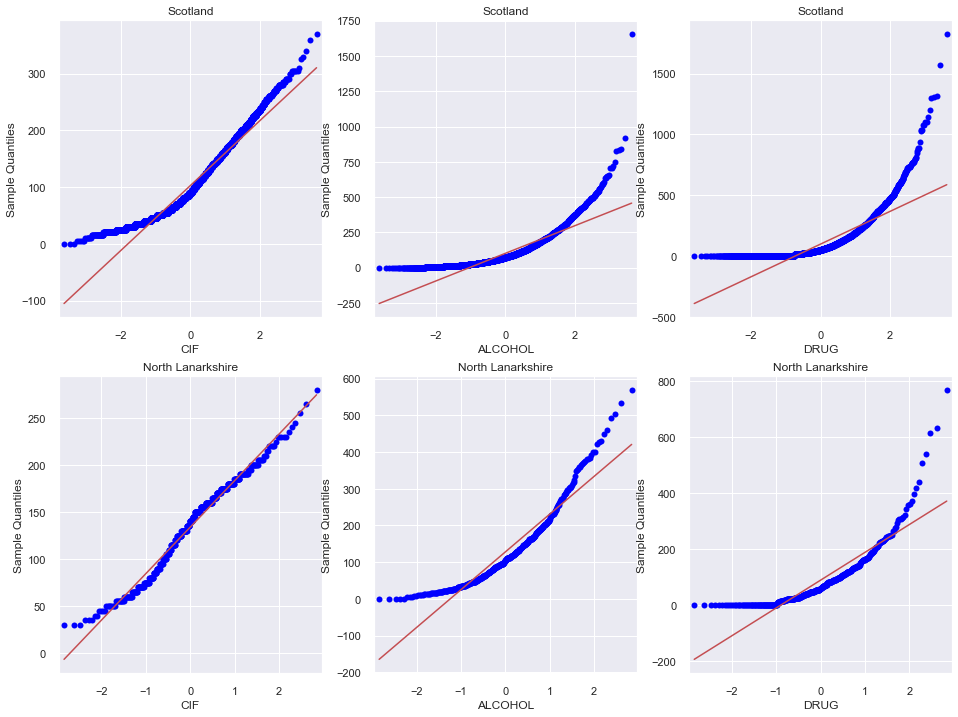

In [17]:
import statsmodels.api as sm
from scipy.stats import norm

#https://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.qqplot.html

#“s” - standardized line, the expected order statistics are scaled by the standard deviation of the given sample and have the mean added to them

fig, axs = plt.subplots(2, 3, figsize=(16, 12))

sm.qqplot(data=simd.CIF, line='s', marker='o',ax=axs[0, 0])
axs[0,0].set(xlabel='CIF', title='Scotland')

sm.qqplot(simd.ALCOHOL, line='s',ax=axs[0, 1])
axs[0,1].set(xlabel='ALCOHOL', title='Scotland')

sm.qqplot(simd.DRUG, line='s',ax=axs[0, 2])
axs[0,2].set(xlabel='DRUG', title='Scotland')

sm.qqplot(nlc.CIF, line='s',ax=axs[1, 0])
axs[1,0].set(xlabel='CIF', title='North Lanarkshire')

sm.qqplot(nlc.ALCOHOL, line='s',ax=axs[1, 1])
axs[1,1].set(xlabel='ALCOHOL', title='North Lanarkshire')

sm.qqplot(nlc.DRUG, line='s',ax=axs[1, 2])
axs[1,2].set(xlabel='DRUG', title='North Lanarkshire')

plt.show()

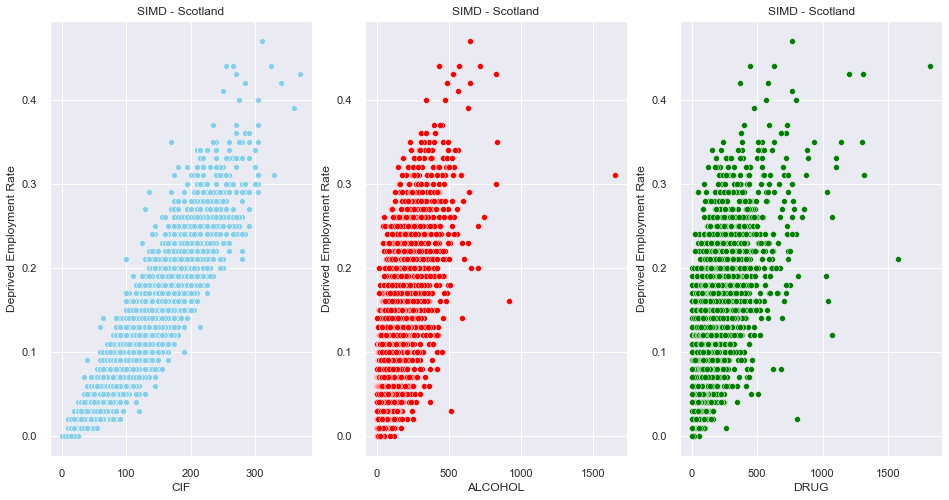

In [18]:
# Lets plot the data, both independent variables represents a standarised indicator where 100 is the Scotland average.
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
sns.scatterplot(x='CIF',y ='Employment_rate', data = simd, color="skyblue", ax=axs[0])
axs[0].set(xlabel='CIF', title='SIMD - Scotland',ylabel='Deprived Employment Rate')
sns.scatterplot(x='ALCOHOL',y ='Employment_rate', data = simd, color="red", ax=axs[1])
axs[1].set(xlabel='ALCOHOL', title='SIMD - Scotland', ylabel='Deprived Employment Rate')
sns.scatterplot(x='DRUG',y ='Employment_rate', data = simd, color="green", ax=axs[2])
axs[2].set(xlabel='DRUG', title='SIMD - Scotland', ylabel='Deprived Employment Rate')
plt.show()

As we can see above the CIF distribution is looking fine for Linear regression, however in the emergency we can have some problem related to the outliers. 
We use solution presented here: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/ to deal with the outliers data in the training set.

Considering the fact that ALCOHOL and DRUG features are having relatively insignificant weight in terms of overall Health Domain rank (Scottish Government, Office of the Chief Statistician Scottish Executive (2006), page 24) – and also the fact that all 3 independent variables are still somehow related we have decided to leave just the CIF (Comparative Illness Factor) component as the source for the linear regression model.

<h2>4. Linear Regression Model</h2>

<h3>4.1 Preparing train and test data</h3>

In [19]:
# Independent Features
X = simd[['CIF']] 
# Dependent or Target variable
y = simd.Employment_rate 
X.shape

(6976, 1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)
# summarize the shape of the training dataset
print(X_train.shape, y_train.shape)

(5232, 1) (5232,)


<h3>4.2 Dealing with outliers</h3>

In [21]:
#Initiate Local Outlier Factor
lof = LocalOutlierFactor()
outliers = lof.fit_predict(X_train)
#select all rows that are not outliers
mask = outliers != -1
X_train = X_train[mask]
y_train = y_train[mask]
# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)


(5190, 1) (5190,)


<h3>4.3 Initialisation and model fitting</h3>

In [22]:
# Create linear regression model
simd_linear_regression = LinearRegression()
 
# Fit the linear regression model
simd_linear_regression.fit(X_train, y_train)
# Predict the values given test set
predictions = simd_linear_regression.predict(X_test)


<h3>4.4 Error Calculation</h3>

In [23]:
#Folowing Errors were calculated for the model
MAE = mean_absolute_error(y_test,predictions)
MSE = mean_squared_error(y_test, predictions)
RMSE = np.sqrt(MSE)
RMSE2 = 2 * RMSE  # 2*sigma ~ 95% confidence region


# Evaluate mean absolute error
print("Mean Absolute Error(MAE): {0}".format(MAE))
 
# Evaluate mean squared error
print("Mean Squared Error(MSE): {0}".format(MSE))  
 
# Evaluate root mean squared error
print("Root Mean Squared Error(RMSE): {0}".format(RMSE))
 
# Evaluate R2-square
print("RMSE2 - 2 sigma ~ 95% confidence region : {0}".format(RMSE2))

Mean Absolute Error(MAE): 0.017961644820031958
Mean Squared Error(MSE): 0.0006200188993145514
Root Mean Squared Error(RMSE): 0.02490017870045417
RMSE2 - 2 sigma ~ 95% confidence region : 0.04980035740090834


<h3>4.4 Linear Regression model visualisation</h3>

LM Intercept:-0.023132021259629695
LM Coefficient:0.001155444853929932


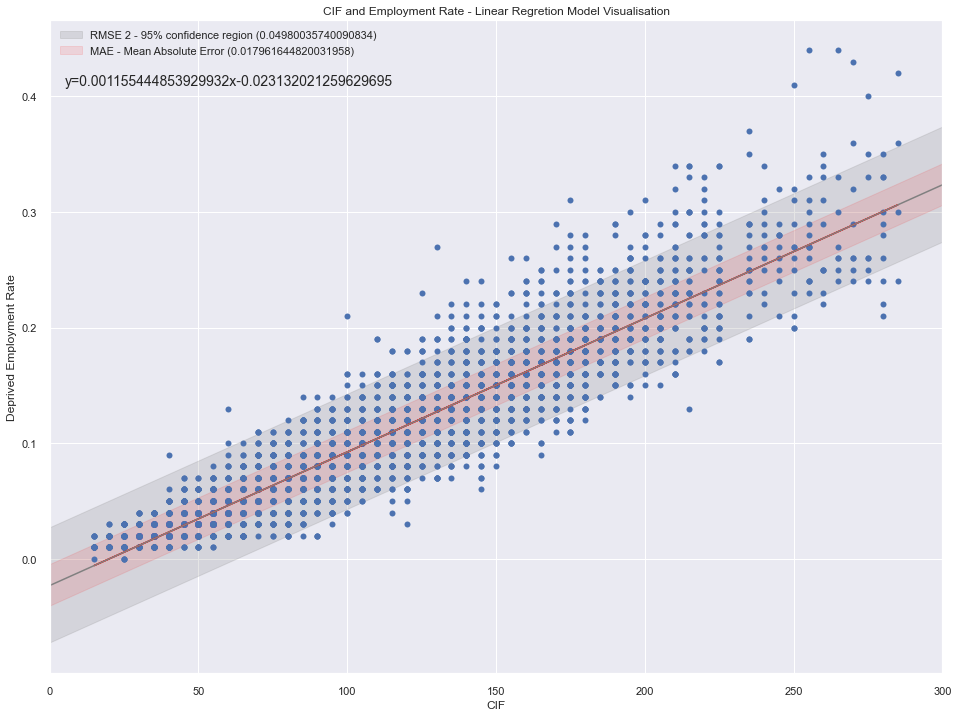

In [24]:
# Print the intercept and coefficients
print('LM Intercept:' + str(simd_linear_regression.intercept_))
print('LM Coefficient:' + str(simd_linear_regression.coef_[0]))
# Plotting a linear regression line on a scatter plot 
# Displays a scatter plot of data along with a line of best fit for the data.
plt.subplots(figsize=(16,12))
plt.title("CIF and Employment Rate - Linear Regretion Model Visualisation")
plt.xlabel("CIF")
plt.ylabel("Deprived Employment Rate")
plt.plot(X_train, y_train, 'o')

#Plot regression line
plt.plot(X_train, simd_linear_regression.coef_*X_train + simd_linear_regression.intercept_,color='red', alpha=0.8)

equasion = "y={0}x{1}".format(simd_linear_regression.coef_[0],simd_linear_regression.intercept_)
plt.annotate(equasion,(5,0.41),fontsize=14)

# Two Errors ranges have been added to the plot utilising continues method described here:
# https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html

xfit = np.linspace(0, 350, 1000) # https://numpy.org/doc/stable/reference/generated/numpy.linspace.html
yfit = simd_linear_regression.predict((xfit[:, np.newaxis])) # https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis

plt.plot(xfit, yfit, '-', color='gray')
plt.fill_between(xfit, yfit - RMSE2, yfit + RMSE2,
                 color='gray', alpha=0.2, label="RMSE 2 - 95% confidence region ({0})".format(RMSE2) )
plt.fill_between(xfit, yfit - MAE, yfit + MAE,
                 color='red', alpha=0.1, label = "MAE - Mean Absolute Error ({0})".format(MAE) )
plt.legend()
plt.xlim(0, 300);






<h2>5. Linear Regression Model Evaluation</h2>

Text(0, 0.5, 'Predictions')

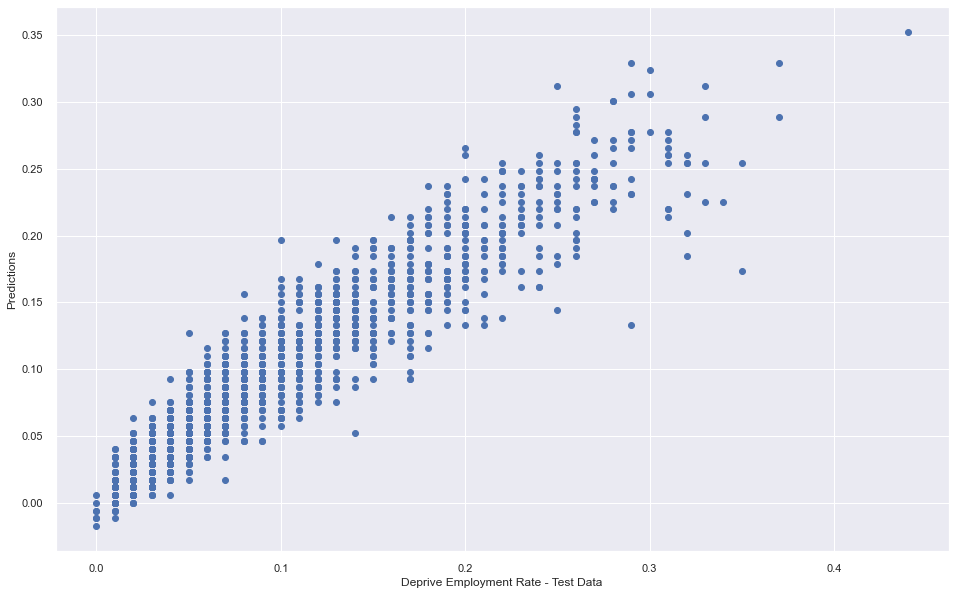

In [25]:
#To see how predictions align with the test data we can plot Test Data (target variable) against predictions results
plt.subplots(figsize=(16,10))
plt.scatter(y_test,predictions)
plt.xlabel('Deprive Employment Rate - Test Data')
plt.ylabel('Predictions')



<AxesSubplot:xlabel='Employment_rate', ylabel='Density'>

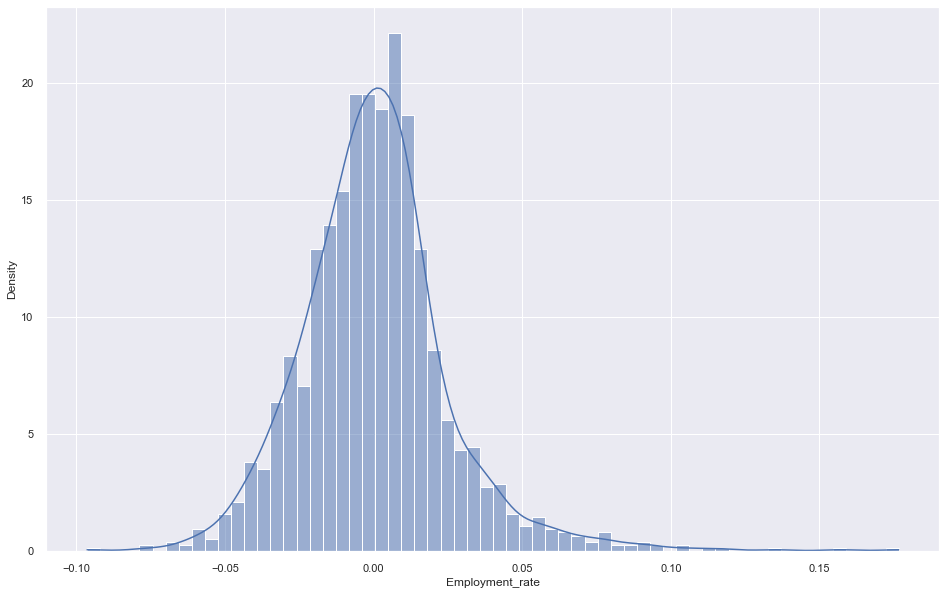

In [26]:
#plotting the residuals
plt.subplots(figsize=(16,10))
sns.histplot(y_test-predictions,kde=True, stat="density", linewidth=1)
#normal distribution indicates that the model is doing well

Residuals, in the context of regression models, are the difference between the observed value of the target variable (y) and the predicted value (ŷ), i.e. the error of the prediction. The residuals plot shows the difference between residuals on the vertical axis and the dependent variable on the horizontal axis, allowing you to detect regions within the target that may be susceptible to more or less error. - Source: https://www.scikit-yb.org/en/latest/api/regressor/residuals.html

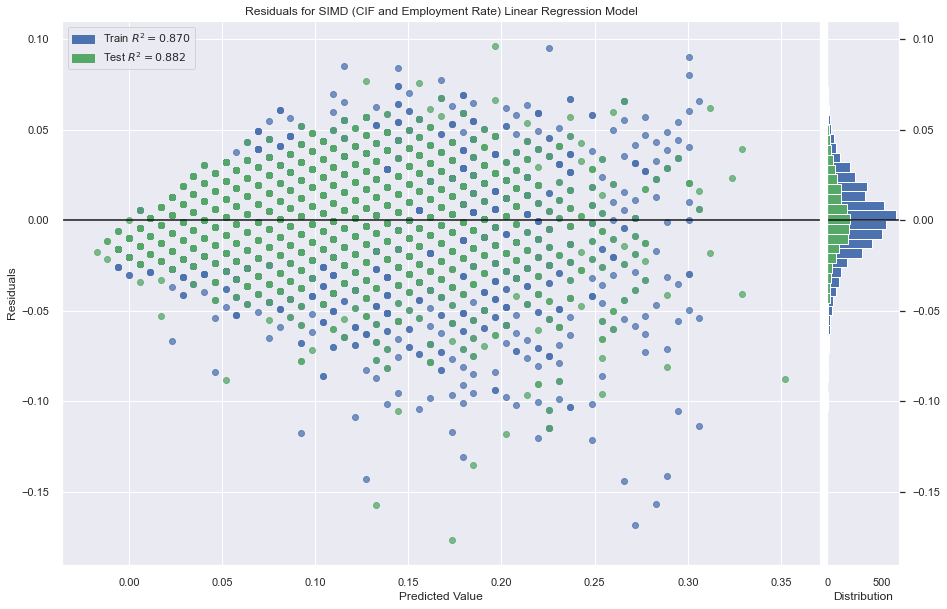

<AxesSubplot:title={'center':'Residuals for SIMD (CIF and Employment Rate) Linear Regression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [27]:
visualizer = ResidualsPlot(simd_linear_regression, size=(1080, 720), title='Residuals for SIMD (CIF and Employment Rate) Linear Regression Model')
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

A common use of the residuals plot is to analyze the variance of the error of the regressor. If the points are randomly dispersed around the horizontal axis, a linear regression model is usually appropriate for the data; otherwise, a non-linear model is more appropriate. In the case above, we see a fairly random, uniform distribution of the residuals against the target in two dimensions. This seems to indicate that our linear model is performing well. We can also see from the histogram that our error is normally distributed around zero, which also generally indicates a well fitted model.

In [28]:
X_test1=([[100]])
predictions = simd_linear_regression.predict(X_test1)

# Print the intercept and coefficients
print(simd_linear_regression.intercept_)
print(simd_linear_regression.coef_)
print(predictions)

-0.023132021259629695
[0.00115544]
[0.09241246]


<h2>6. Next Steps - North Lanarkshire Context</h2>

For the next steps we will concentrate on analysies and model building for North Lanarkshire. This allows to determin the priorities e.g. by identifying areas (data zones) with biggest problems as well alllows to forcast how improving the general helth within communities could improve the employment rate, which (as other studies show) is inportant factor for the improvement of the quality of live in a wide aspect.

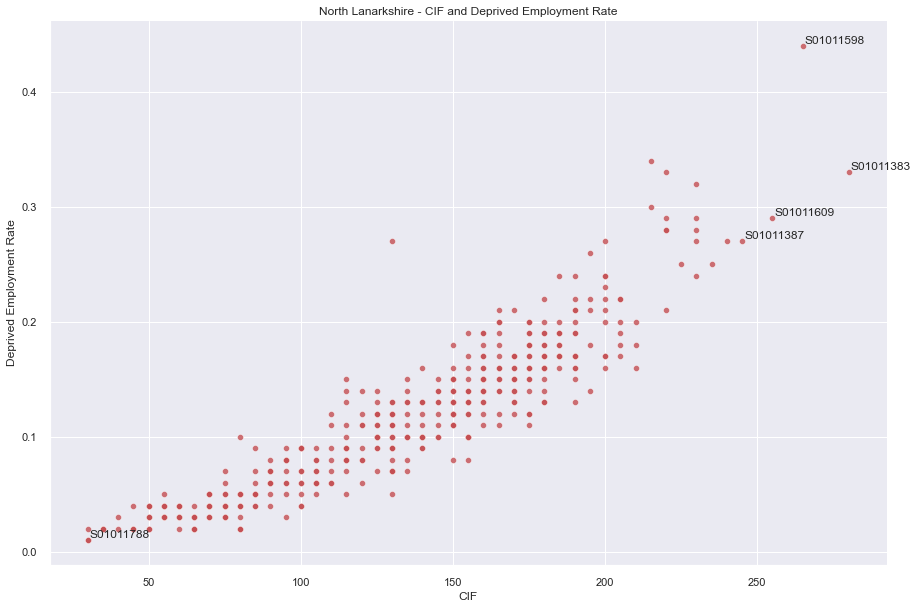

In [29]:
g=sns.scatterplot(x="CIF", y="Employment_rate", data=nlc, color="r", alpha=0.8)
g.set(title='North Lanarkshire - CIF and Deprived Employment Rate', xlabel='CIF', ylabel='Deprived Employment Rate')
g.figure.set_size_inches(15, 10)


#indices to annotate
head = nlc.sort_values(by=['CIF'], ascending=[False]).head(4)
tail = nlc.sort_values(by=['CIF'], ascending=[False]).tail(1)

def annotate(row):
    index = row[0]
    r = row[1]
    plt.annotate(r['Data_Zone'], xy=(r["CIF"], r["Employment_rate"]), 
            xytext=(2,2) , textcoords ="offset points" )

for row in head.iterrows():
    annotate(row)
for row in tail.iterrows():
    annotate(row)

sns.despine()

In [30]:
#Select 50 most affected datazones by the high CIF value
nlc_CIF_head = nlc.sort_values(by=['CIF'], ascending=[False]).head(50)
nlc_CIF_head.head(10)

#Rename column Employment_rate to DER (Deprived Employment Rate)
nlc_CIF_head.rename(columns={"Employment_rate": "DER"}, inplace=True)
nlc_CIF_head.head(10)

,Data_Zone,Intermediate_Zone,Council_area,DER,CIF,ALCOHOL,DRUG
4877,S01011383,Craigneuk Wishaw,North Lanarkshire,0.33,280,374,303
5092,S01011598,Cliftonville,North Lanarkshire,0.44,265,570,632
5103,S01011609,Greenend and Carnbroe,North Lanarkshire,0.29,255,400,314
4881,S01011387,Craigneuk Wishaw,North Lanarkshire,0.27,245,360,418
5150,S01011656,Thrashbush,North Lanarkshire,0.27,240,318,310
4982,S01011488,Motherwell North,North Lanarkshire,0.25,235,180,356
4969,S01011475,Motherwell South,North Lanarkshire,0.32,230,504,278
5065,S01011571,Dundyvan,North Lanarkshire,0.24,230,273,242
4914,S01011420,Newmains,North Lanarkshire,0.27,230,306,84
5075,S01011581,Coatbridge West,North Lanarkshire,0.28,230,431,207


In [31]:
#Introduce 2 new variables C50L (CIF less 50) and C100L (CIF less 100)
#These will be used by the model to predict new values of deprived employment rate
nlc_CIF_head['C50L'] = nlc_CIF_head['CIF']-50
nlc_CIF_head['C100L'] = nlc_CIF_head['CIF']-100
nlc_CIF_head.head(10)

,Data_Zone,Intermediate_Zone,Council_area,DER,CIF,ALCOHOL,DRUG,C50L,C100L
4877,S01011383,Craigneuk Wishaw,North Lanarkshire,0.33,280,374,303,230,180
5092,S01011598,Cliftonville,North Lanarkshire,0.44,265,570,632,215,165
5103,S01011609,Greenend and Carnbroe,North Lanarkshire,0.29,255,400,314,205,155
4881,S01011387,Craigneuk Wishaw,North Lanarkshire,0.27,245,360,418,195,145
5150,S01011656,Thrashbush,North Lanarkshire,0.27,240,318,310,190,140
4982,S01011488,Motherwell North,North Lanarkshire,0.25,235,180,356,185,135
4969,S01011475,Motherwell South,North Lanarkshire,0.32,230,504,278,180,130
5065,S01011571,Dundyvan,North Lanarkshire,0.24,230,273,242,180,130
4914,S01011420,Newmains,North Lanarkshire,0.27,230,306,84,180,130
5075,S01011581,Coatbridge West,North Lanarkshire,0.28,230,431,207,180,130


In [32]:
#Prepare input arrays for Linear Regression Model
X_input_C50L=(nlc_CIF_head['C50L'].to_numpy()[:,np.newaxis])
X_input_C100L=(nlc_CIF_head['C100L'].to_numpy()[:,np.newaxis])

#Execute Linear Regression Model
C50P = simd_linear_regression.predict(X_input_C50L)
C100P = simd_linear_regression.predict(X_input_C100L)

#Assign predicted value to the dataframe
nlc_CIF_head['D50L'] = C50P
nlc_CIF_head['D100L'] = C100P

nlc_CIF_head.head(10)


,Data_Zone,Intermediate_Zone,Council_area,DER,CIF,ALCOHOL,DRUG,C50L,C100L,D50L,D100L
4877,S01011383,Craigneuk Wishaw,North Lanarkshire,0.33,280,374,303,230,180,0.242620,0.184848
5092,S01011598,Cliftonville,North Lanarkshire,0.44,265,570,632,215,165,0.225289,0.167516
5103,S01011609,Greenend and Carnbroe,North Lanarkshire,0.29,255,400,314,205,155,0.213734,0.155962
4881,S01011387,Craigneuk Wishaw,North Lanarkshire,0.27,245,360,418,195,145,0.202180,0.144407
5150,S01011656,Thrashbush,North Lanarkshire,0.27,240,318,310,190,140,0.196403,0.138630
4982,S01011488,Motherwell North,North Lanarkshire,0.25,235,180,356,185,135,0.190625,0.132853
4969,S01011475,Motherwell South,North Lanarkshire,0.32,230,504,278,180,130,0.184848,0.127076
5065,S01011571,Dundyvan,North Lanarkshire,0.24,230,273,242,180,130,0.184848,0.127076
4914,S01011420,Newmains,North Lanarkshire,0.27,230,306,84,180,130,0.184848,0.127076
5075,S01011581,Coatbridge West,North Lanarkshire,0.28,230,431,207,180,130,0.184848,0.127076


In [33]:
#Lets assume we have only achived improvement in CIF factor in those 10 selected Data Zones
#Check how this affect mean value for NLC as a whole

#Rename column Employment_rate to DER (Deprived Employment Rate)
nlc.rename(columns={"Employment_rate": "DER"}, inplace=True)

#Take a copy of the original nlc dataframe
nlc1 = nlc.copy()

#Initially populate all new columns with initial values
nlc1['C50L'] = nlc1['CIF']
nlc1['C100L'] = nlc1['CIF']
nlc1['D50L'] = nlc1['DER']
nlc1['D100L'] = nlc1['DER']


nlc1.loc[nlc1.Data_Zone.isin(nlc_CIF_head.Data_Zone), ['C50L', 'C100L','D50L','D100L']] = nlc_CIF_head[['C50L', 'C100L','D50L','D100L']]
nlc1.describe()

,DER,CIF,ALCOHOL,DRUG,C50L,C100L,D50L,D100L
count,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000
mean,0.117562,134.071588,128.049217,88.595078,128.478747,122.885906,0.109935,0.103473
std,0.068328,49.498374,103.149973,99.522849,42.750595,41.267127,0.055075,0.051649
min,0.010000,30.000000,0.000000,0.000000,30.000000,30.000000,0.010000,0.010000
25%,0.060000,95.000000,48.500000,21.000000,95.000000,90.000000,0.060000,0.060000
50%,0.120000,140.000000,105.000000,59.000000,140.000000,125.000000,0.120000,0.100000
75%,0.160000,170.000000,173.500000,121.000000,160.000000,160.000000,0.150185,0.140000
max,0.440000,280.000000,570.000000,769.000000,230.000000,190.000000,0.270000,0.270000


In [34]:
#In contrary instead of targetting 50 most affected data zones by CIF and Employment Depravation
#lets try to set a target of reducing the CIF in all data zones by 10% and 15% to see what the prediction could be.

#Prepare predicting variables
nlc2 = nlc.copy()
nlc2['C10L'] = nlc['CIF'] - nlc['CIF']*0.10
nlc2['C15L'] = nlc['CIF'] - nlc['CIF']*0.15

#Prepare input arrays for Linear Regression Model
X_input_C10L=(nlc2['C10L'].to_numpy()[:,np.newaxis])
X_input_C15L=(nlc2['C15L'].to_numpy()[:,np.newaxis])

#Execute Linear Regression Model
D10L = simd_linear_regression.predict(X_input_C10L)
D15L = simd_linear_regression.predict(X_input_C15L)

#Initially populate the target variables with original data
nlc2['D10L'] = D10L
nlc2['D15L'] = D15L

nlc2.describe()

,DER,CIF,ALCOHOL,DRUG,C10L,C15L,D10L,D15L
count,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000
mean,0.117562,134.071588,128.049217,88.595078,120.664430,113.960850,0.116289,0.108543
std,0.068328,49.498374,103.149973,99.522849,44.548537,42.073618,0.051473,0.048614
min,0.010000,30.000000,0.000000,0.000000,27.000000,25.500000,0.008065,0.006332
25%,0.060000,95.000000,48.500000,21.000000,85.500000,80.750000,0.075659,0.070170
50%,0.120000,140.000000,105.000000,59.000000,126.000000,119.000000,0.122454,0.114366
75%,0.160000,170.000000,173.500000,121.000000,153.000000,144.500000,0.153651,0.143830
max,0.440000,280.000000,570.000000,769.000000,252.000000,238.000000,0.268040,0.251864
